# 概要
モデルを作成する

In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
import re
from urllib.request import urlopen
from itertools import combinations, permutations
import matplotlib.pyplot as plt
import pickle
import optuna.integration.lightgbm as lgb_o

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
import module.Preprocessing as preprocessing
import module.Simulation as simulation

レース結果データ、馬情報データ、払い戻し情報の読み込み

In [6]:
race_resluts = pd.read_pickle("data/race_results.pickle")
horse_results = pd.read_pickle("data/horse_results.pickle")
return_table = pd.read_pickle("data/return_tables.pickle")

レース結果データ、馬情報データの前処理をする

In [7]:
p_race_results = preprocessing.race_preprocessing(race_resluts)
p_horse_results = preprocessing.horse_preprocessing(horse_results)
pd.to_pickle(p_race_results,"data/preprocessing_data/p_race_results.pickle")
pd.to_pickle(p_horse_results,"data/preprocessing_data/p_horse_results.pickle")

c:\keiba\keiba\module\Preprocessing.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["着順"] = pd.to_numeric(df["着順"], errors="coerce")
c:\keiba\keiba\module\Preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["着順"], inplace=True)
c:\keiba\keiba\module\Preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

レース結果データに馬の過去成績を追加する

In [6]:
m_race_results = preprocessing.merge_race_with_horse(p_race_results, p_horse_results)
pd.to_pickle(m_race_results,"data/preprocessing_data/m_race_results.pickle")

horse_idとjockey_idをラベルエンコーディングして、保存する（出馬表データの前処理で使用するので）

In [10]:
le_horse = LabelEncoder().fit(m_race_results["horse_id"])
le_jockey = LabelEncoder().fit(m_race_results["jockey_id"])
# ラベルエンコーダーの保存
# pickle.dump(le_horse, open("labelencoder/le_horse.pickle", 'wb'))
# pickle.dump(le_jockey, open("labelencoder/le_jockey.pickle", 'wb'))

ダミー変数化する

In [11]:
d_race_results = preprocessing.dummy_with_category(le_horse, le_jockey, m_race_results, m_race_results)

時系列に沿って訓練データとテストデータに分ける関数

In [12]:
#時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
  sorted_id_list = df.sort_values("date").index.unique()
  train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
  test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
  train = df.loc[train_id_list]
  test = df.loc[test_id_list]
  return train, test

In [13]:
train, valid  = split_data(d_race_results)

In [14]:
X_train = train.drop(['rank', 'date', "着順", "単勝"], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date', "着順", "単勝"], axis=1)
y_valid = valid['rank']

パラメータチューニング（いい感じのパラメーターにしてくれる）

In [12]:
#データセットを作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective': 'binary', #二値予測の場合はbinary
    'random_state': 100
}

#チューニング実行
lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10,
                        optuna_seed=100
                        )

[I 2023-02-06 01:40:16,546] A new study created in memory with name: no-name-844fe396-066e-4bdd-bfe0-f5d7a6bb5c88
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]c:\keiba\keiba\env\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\keiba\keiba\env\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414732:  14%|#4        | 1/7 [00:00<00:03,  1.97it/s]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.408885	valid_1's binary_logloss: 0.414732
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414707:  29%|##8       | 2/7 [00:01<00:02,  1.88it/s]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.409233	valid_1's binary_logloss: 0.414707
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414469:  43%|####2     | 3/7 [00:01<00:02,  1.96it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.410492	valid_1's binary_logloss: 0.414469
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414469:  57%|#####7    | 4/7 [00:02<00:01,  1.83it/s]

[100]	valid_0's binary_logloss: 0.404286	valid_1's binary_logloss: 0.414978
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.405115	valid_1's binary_logloss: 0.414951
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414469:  71%|#######1  | 5/7 [00:02<00:01,  1.80it/s]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.406642	valid_1's binary_logloss: 0.414982
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414469:  86%|########5 | 6/7 [00:03<00:00,  1.87it/s]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.409466	valid_1's binary_logloss: 0.414525
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.414469: 100%|##########| 7/7 [00:03<00:00,  1.86it/s]


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.407935	valid_1's binary_logloss: 0.414579


num_leaves, val_score: 0.414469:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414469:   5%|5         | 1/20 [00:00<00:11,  1.64it/s]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.38515	valid_1's binary_logloss: 0.416492
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414469:  10%|#         | 2/20 [00:01<00:10,  1.75it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.398835	valid_1's binary_logloss: 0.415632
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414469:  15%|#5        | 3/20 [00:01<00:09,  1.72it/s]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.392609	valid_1's binary_logloss: 0.416214
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414469:  20%|##        | 4/20 [00:02<00:10,  1.51it/s]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.36533	valid_1's binary_logloss: 0.417788
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.418737	valid_1's binary_logloss: 0.415274
[200]	valid_0's binary_logloss: 0.417418	valid_1's binary_logloss: 0.414611


num_leaves, val_score: 0.414469:  25%|##5       | 5/20 [00:03<00:09,  1.55it/s]

Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.417377	valid_1's binary_logloss: 0.414606
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414163:  30%|###       | 6/20 [00:03<00:08,  1.62it/s]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.407112	valid_1's binary_logloss: 0.414163
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414163:  35%|###5      | 7/20 [00:04<00:08,  1.56it/s]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.37723	valid_1's binary_logloss: 0.41705
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414163:  40%|####      | 8/20 [00:05<00:08,  1.43it/s]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.370421	valid_1's binary_logloss: 0.41753
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414163:  45%|####5     | 9/20 [00:05<00:07,  1.53it/s]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.408531	valid_1's binary_logloss: 0.414642
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414163:  50%|#####     | 10/20 [00:06<00:06,  1.56it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.385934	valid_1's binary_logloss: 0.416613
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414163:  55%|#####5    | 11/20 [00:06<00:05,  1.66it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.400092	valid_1's binary_logloss: 0.415522
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  60%|######    | 12/20 [00:07<00:04,  1.66it/s]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.415356	valid_1's binary_logloss: 0.414128
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.420481	valid_1's binary_logloss: 0.416502
[200]	valid_0's binary_logloss: 0.419574	valid_1's binary_logloss: 0.415843
[300]	valid_0's binary_logloss: 0.419204	valid_1's binary_logloss: 0.415661


num_leaves, val_score: 0.414128:  65%|######5   | 13/20 [00:08<00:04,  1.44it/s]

Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.41911	valid_1's binary_logloss: 0.415617
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  70%|#######   | 14/20 [00:08<00:03,  1.53it/s]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.399857	valid_1's binary_logloss: 0.4147
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  75%|#######5  | 15/20 [00:09<00:03,  1.56it/s]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.388407	valid_1's binary_logloss: 0.416065
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  80%|########  | 16/20 [00:10<00:02,  1.64it/s]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.410933	valid_1's binary_logloss: 0.414542
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  85%|########5 | 17/20 [00:10<00:01,  1.67it/s]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.397192	valid_1's binary_logloss: 0.415683
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  90%|######### | 18/20 [00:11<00:01,  1.77it/s]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.408816	valid_1's binary_logloss: 0.414353
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128:  95%|#########5| 19/20 [00:11<00:00,  1.79it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.403582	valid_1's binary_logloss: 0.415204
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.414128: 100%|##########| 20/20 [00:12<00:00,  1.58it/s]


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.363953	valid_1's binary_logloss: 0.418104


bagging, val_score: 0.414128:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414128:  10%|#         | 1/10 [00:00<00:04,  2.13it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415257	valid_1's binary_logloss: 0.414276
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414128:  20%|##        | 2/10 [00:00<00:03,  2.08it/s]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.41574	valid_1's binary_logloss: 0.414334
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414128:  30%|###       | 3/10 [00:01<00:03,  1.88it/s]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.415469	valid_1's binary_logloss: 0.414844
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000:  40%|####      | 4/10 [00:02<00:03,  1.74it/s]

[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000:  50%|#####     | 5/10 [00:02<00:02,  1.78it/s]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.415229	valid_1's binary_logloss: 0.414372
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000:  60%|######    | 6/10 [00:03<00:02,  1.77it/s]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.415248	valid_1's binary_logloss: 0.414226
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000:  70%|#######   | 7/10 [00:03<00:01,  1.87it/s]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.416566	valid_1's binary_logloss: 0.414662
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000:  80%|########  | 8/10 [00:04<00:01,  1.95it/s]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.41627	valid_1's binary_logloss: 0.414501
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000:  90%|######### | 9/10 [00:04<00:00,  1.83it/s]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.415426	valid_1's binary_logloss: 0.414275
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.414000: 100%|##########| 10/10 [00:05<00:00,  1.84it/s]


Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.415907	valid_1's binary_logloss: 0.414263


feature_fraction_stage2, val_score: 0.414000:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.414000:  17%|#6        | 1/6 [00:00<00:02,  1.86it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415296	valid_1's binary_logloss: 0.414191
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.414000:  33%|###3      | 2/6 [00:01<00:02,  1.77it/s]

[100]	valid_0's binary_logloss: 0.414466	valid_1's binary_logloss: 0.414118
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.414872	valid_1's binary_logloss: 0.414064
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.414000:  50%|#####     | 3/6 [00:01<00:01,  1.68it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415305	valid_1's binary_logloss: 0.41417
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.414000:  67%|######6   | 4/6 [00:02<00:01,  1.71it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415504	valid_1's binary_logloss: 0.414493
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.414000:  83%|########3 | 5/6 [00:03<00:00,  1.61it/s]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.414894	valid_1's binary_logloss: 0.414048
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.414000: 100%|##########| 6/6 [00:03<00:00,  1.65it/s]


[100]	valid_0's binary_logloss: 0.414484	valid_1's binary_logloss: 0.414051
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.414586	valid_1's binary_logloss: 0.414027


regularization_factors, val_score: 0.414000:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:   5%|5         | 1/20 [00:00<00:12,  1.56it/s]

[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  10%|#         | 2/20 [00:01<00:11,  1.63it/s]

[100]	valid_0's binary_logloss: 0.414632	valid_1's binary_logloss: 0.414166
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.414918	valid_1's binary_logloss: 0.414135
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  15%|#5        | 3/20 [00:01<00:10,  1.55it/s]

[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  20%|##        | 4/20 [00:02<00:10,  1.59it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415368	valid_1's binary_logloss: 0.414144
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  25%|##5       | 5/20 [00:03<00:09,  1.65it/s]

[100]	valid_0's binary_logloss: 0.414483	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.41495	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  30%|###       | 6/20 [00:03<00:08,  1.59it/s]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.415184	valid_1's binary_logloss: 0.414123
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  35%|###5      | 7/20 [00:04<00:08,  1.58it/s]

[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  40%|####      | 8/20 [00:05<00:07,  1.59it/s]

[100]	valid_0's binary_logloss: 0.414865	valid_1's binary_logloss: 0.414123
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.415119	valid_1's binary_logloss: 0.41408
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  45%|####5     | 9/20 [00:05<00:06,  1.60it/s]

[100]	valid_0's binary_logloss: 0.414594	valid_1's binary_logloss: 0.414152
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.414998	valid_1's binary_logloss: 0.414129
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  50%|#####     | 10/20 [00:06<00:06,  1.59it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415397	valid_1's binary_logloss: 0.414077
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  55%|#####5    | 11/20 [00:06<00:05,  1.63it/s]

[100]	valid_0's binary_logloss: 0.414483	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.41495	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  60%|######    | 12/20 [00:07<00:04,  1.65it/s]

[100]	valid_0's binary_logloss: 0.414483	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.41495	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  65%|######5   | 13/20 [00:08<00:04,  1.64it/s]

[100]	valid_0's binary_logloss: 0.414483	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.41495	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.414000:  70%|#######   | 14/20 [00:08<00:03,  1.60it/s]

[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.413998:  75%|#######5  | 15/20 [00:09<00:03,  1.57it/s]

[100]	valid_0's binary_logloss: 0.414496	valid_1's binary_logloss: 0.414071
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414954	valid_1's binary_logloss: 0.413998
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.413998:  80%|########  | 16/20 [00:10<00:02,  1.57it/s]

[100]	valid_0's binary_logloss: 0.414497	valid_1's binary_logloss: 0.414071
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414955	valid_1's binary_logloss: 0.413998
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.413998:  85%|########5 | 17/20 [00:10<00:01,  1.59it/s]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.415232	valid_1's binary_logloss: 0.414049
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.413998:  90%|######### | 18/20 [00:11<00:01,  1.65it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415396	valid_1's binary_logloss: 0.414054
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.413998:  95%|#########5| 19/20 [00:11<00:00,  1.65it/s]

[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.413998: 100%|##########| 20/20 [00:12<00:00,  1.61it/s]


[100]	valid_0's binary_logloss: 0.414482	valid_1's binary_logloss: 0.414052
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.414949	valid_1's binary_logloss: 0.414


min_data_in_leaf, val_score: 0.413998:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.413998:  20%|##        | 1/5 [00:00<00:02,  1.86it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415255	valid_1's binary_logloss: 0.414071
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.413998:  40%|####      | 2/5 [00:01<00:01,  1.71it/s]

[100]	valid_0's binary_logloss: 0.414769	valid_1's binary_logloss: 0.4142
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.415131	valid_1's binary_logloss: 0.414149
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.413998:  60%|######    | 3/5 [00:01<00:01,  1.56it/s]

[100]	valid_0's binary_logloss: 0.414603	valid_1's binary_logloss: 0.414109
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.413857	valid_1's binary_logloss: 0.414035
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.413998:  80%|########  | 4/5 [00:02<00:00,  1.63it/s]

[100]	valid_0's binary_logloss: 0.414604	valid_1's binary_logloss: 0.41405
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.415028	valid_1's binary_logloss: 0.414029
[LightGBM] [Info] Number of positive: 29545, number of negative: 105602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 135147, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218614 -> initscore=-1.273763
[LightGBM] [Info] Start training from score -1.273763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.413998: 100%|##########| 5/5 [00:02<00:00,  1.68it/s]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.415252	valid_1's binary_logloss: 0.414091


In [13]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 3.776149197088745e-05,
 'lambda_l2': 0.009458177602015108,
 'num_leaves': 9,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.802449450836738,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [15]:
params ={'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.490245203532942e-07,
 'lambda_l2': 6.421168438428032,
 'num_leaves': 9,
 'feature_fraction': 0.7,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,}

In [16]:
# 人気のデータあり
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
file = 'model/dangerous_dev.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

c:\keiba\keiba\env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=9.490245203532942e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.490245203532942e-07
[LightGBM] [Warning] lambda_l2 is set=6.421168438428032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.421168438428032
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


### 精度検証

三着以内に入る確率を予想

In [17]:
proba = simulation.predict_proba(lgb_clf, X_valid)
tansho_df = preprocessing.tansho_preprocessing(return_table)
pred_table = simulation.pred_table(proba, valid, tansho_df)

In [18]:
pred_table

,着順,人気,馬番,proba,win,return
202103020201,1,5.0,6,0.384075,6.0,1640.0
202103020201,2,7.0,13,0.346790,6.0,1640.0
202103020201,3,1.0,7,0.797231,6.0,1640.0
202103020201,4,2.0,14,0.679910,6.0,1640.0
202103020201,5,6.0,11,0.372679,6.0,1640.0
...,...,...,...,...,...,...
202310010412,12,12.0,8,0.217667,15.0,630.0
202310010412,13,1.0,13,0.796468,15.0,630.0
202310010412,14,10.0,12,0.221960,15.0,630.0
202310010412,15,7.0,3,0.391126,15.0,630.0


<AxesSubplot: title={'center': 'recovery_rate'}, xlabel='n_bets'>

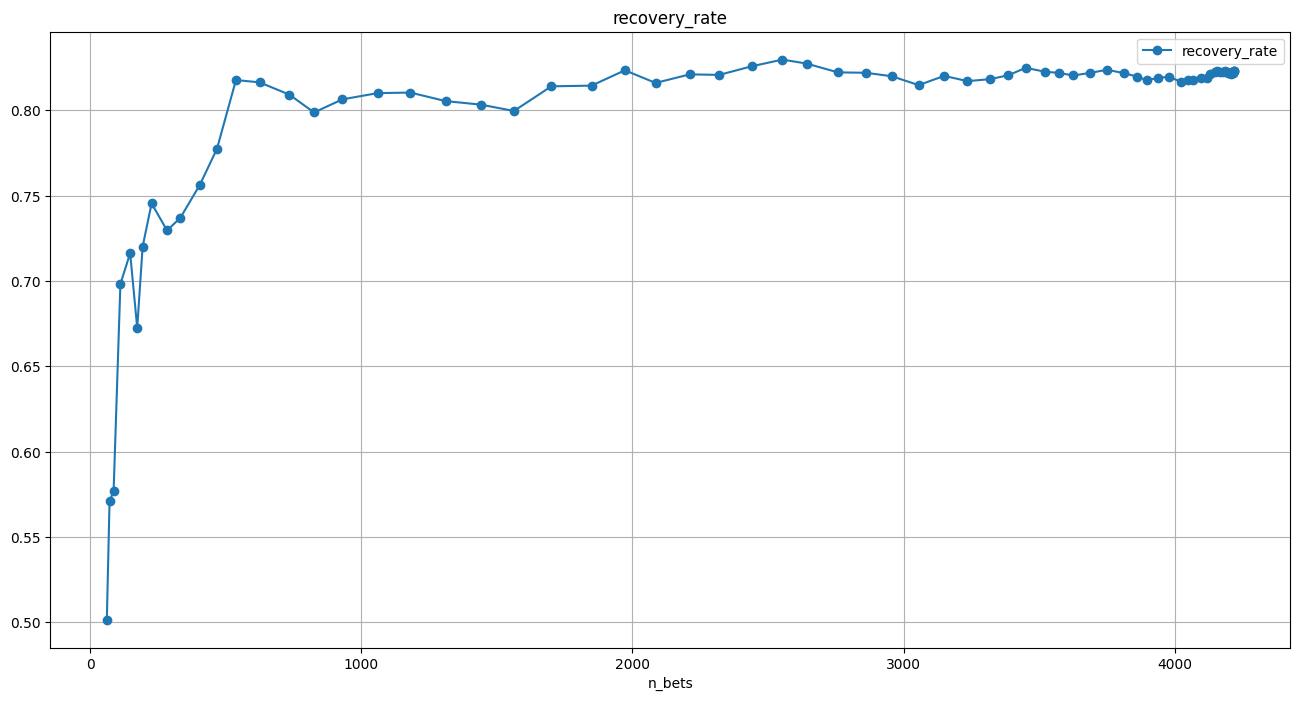

In [23]:
# 同レースで期待値が1番高い馬にかけた時の期待値(単勝)
gain = simulation.same_race_return_bets(pred_table)
df_gain = pd.DataFrame(gain)
df_gain = df_gain.reset_index()
df_gain.columns = ["n_bets","recovery_rate"]
df_gain.plot(
  figsize=(16, 8), style=['o-'], grid=True, x="n_bets", title="recovery_rate"
)

<AxesSubplot: title={'center': 'recovery_rate'}, xlabel='n_bets'>

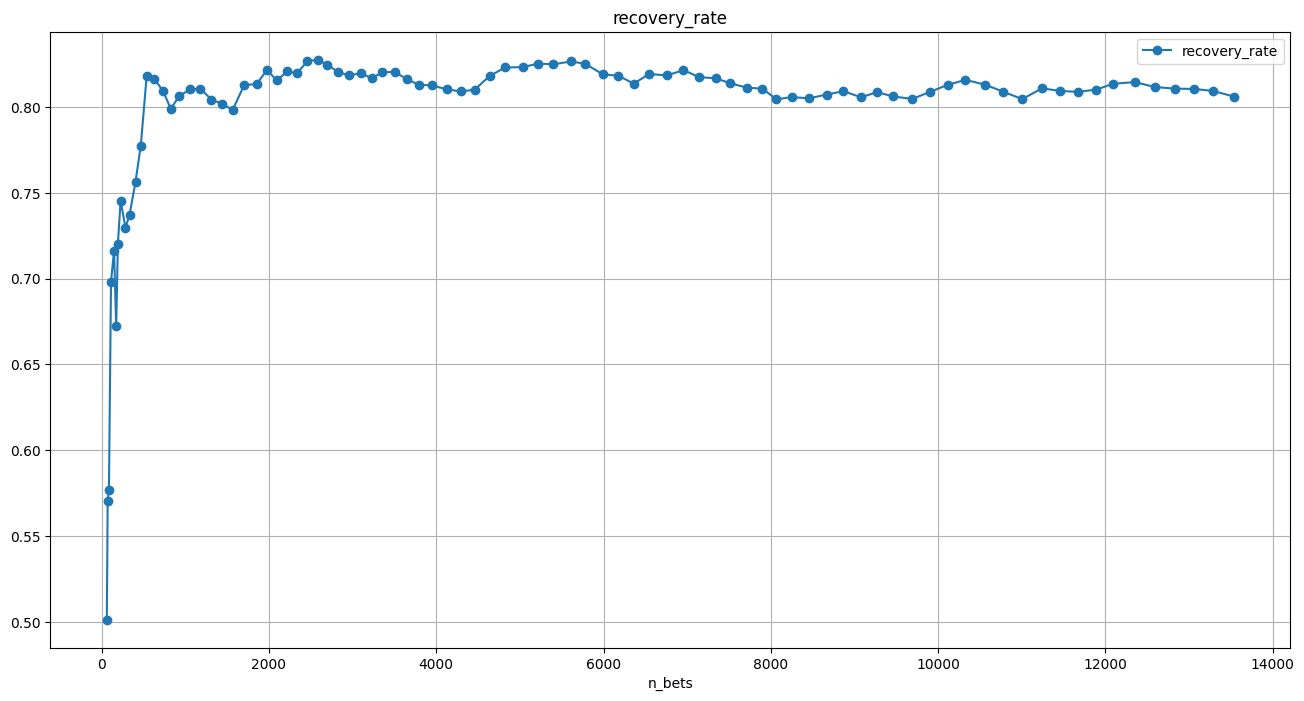

In [24]:
# 期待値がthreshold以上の馬にかけた時の期待値(単勝)
gain = simulation.race_return_bets(pred_table)
df_gain = pd.DataFrame(gain)
df_gain = df_gain.reset_index()
df_gain.columns = ["n_bets","recovery_rate"]
df_gain.plot(
  figsize=(16, 8), style=['o-'], grid=True, x="n_bets", title="recovery_rate"
)

<AxesSubplot: title={'center': 'recovery_rate'}, xlabel='n_bets'>

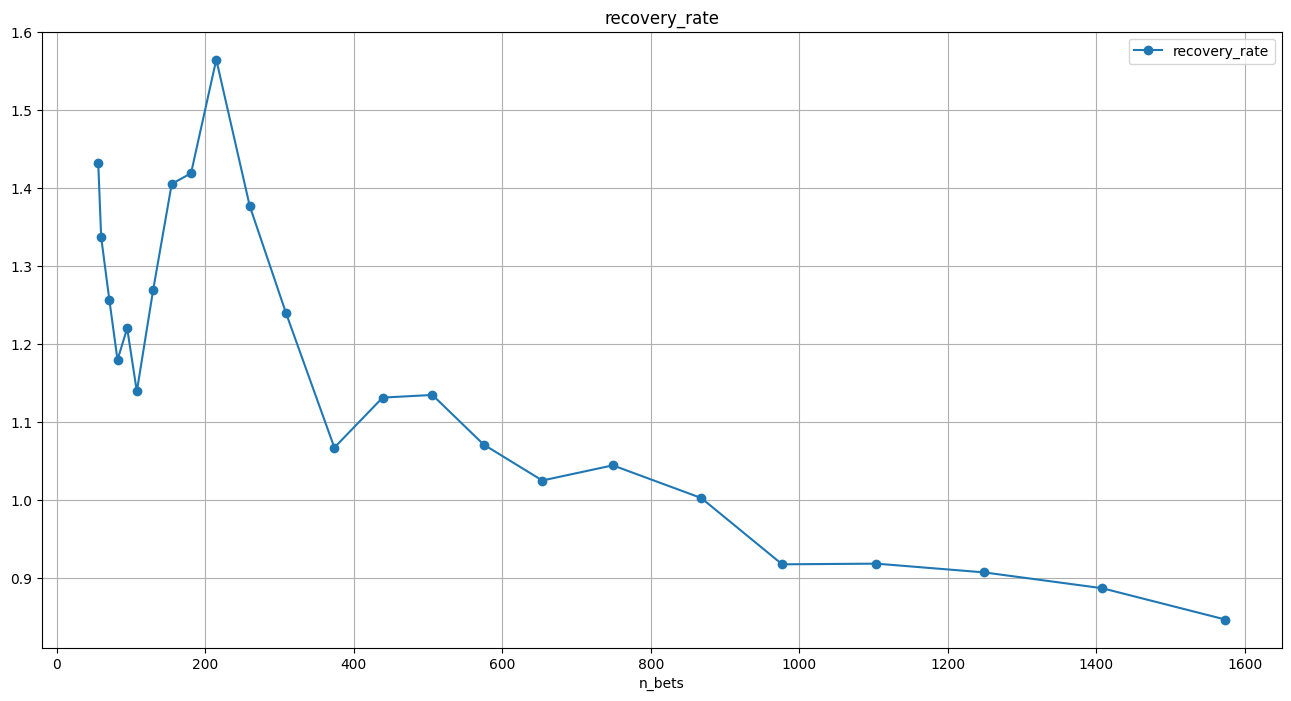

In [25]:
# 人気が３位以内ではない馬にかけた時の期待値
gain = simulation.race_return_not_popular_bets(pred_table)
df_gain = pd.DataFrame(gain)
df_gain = df_gain.reset_index()
df_gain.columns = ["n_bets","recovery_rate"]
df_gain.plot(
  figsize=(16, 8), style=['o-'], grid=True, x="n_bets", title="recovery_rate"
)

## 本番用のモデルを保存

In [21]:
X_all_data = d_race_results.drop(['rank', 'date', "着順", "単勝"], axis=1)
y_all_data = d_race_results["rank"]
# 人気のデータあり
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_all_data.values, y_all_data.values)
file = 'model/dangerous_pred.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

c:\keiba\keiba\env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=9.490245203532942e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.490245203532942e-07
[LightGBM] [Warning] lambda_l2 is set=6.421168438428032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.421168438428032
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
